## Stochastic environment 


In [16]:
import numpy as np
#import jax.numpy as np
import matplotlib.pyplot as plt
import Configuration as config
from scipy import stats
from scipy import optimize
from tqdm import tqdm
from functools import wraps
import time
from scipy.optimize import curve_fit

!python ./Configuration.py      # to have configuration values updated

### Pricing stochastic environment
This class simulates a normalized demand curve (conversion probability) which tells the probability of a product to be bought at a given price. The actual curve is unknown to the agents which indeed has to estimate its shape by means of exploitation-exploration tradeoff. The product has a fixed (production) cost so, depending on the demand curve, there will be an optimal selling price for which the profit will be maximized. This means that if we knew the demand curve, we would also knew the profit curve and, consequently, its max value.

In [17]:
class pricing_stochastic_env:
    def __init__(self, conversion_probability, cost=0.2):
        #self.rewards
        self.cost = cost
        self.conversion_probability = conversion_probability

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost) * d_t      # the reward is equal to the profit given by (price-cost)*expected demand (sampled)
        return d_t, r_t

### Bidding stochastic environment
This class simulates all the auctions agents. We implement second price auctions in multi-slot case so, since we are in truthful auctions, we are implementing VCG auctions dynamics.

In [18]:
class bidding_stochastic_env:
    def __init__(self, B, T, lambdas, n_advertisers):
        self.B = B
        self.T = T
        #self.rho = B/T
        self.lambdas = lambdas
        self.n_slots = len(self.lambdas)
        self.ctrs = np.ones(n_advertisers+1)    # for simplicity we keep them all equal to 1, the +1 is for including myself

    def get_winners(self, bids):
        adv_values = self.ctrs*bids                 # computing values = q*b
        adv_ranking = np.argsort(adv_values)        # array with the index of adv_values sorted in increasing order
        winners = adv_ranking[-self.n_slots:]       # taking the last n_slots indexes, i.e. the indexes of the highest values
        winners_values = adv_values[winners]
        return winners, winners_values

    def get_payments_per_click(self, values, winners):
        payments_per_click = np.zeros(self.n_slots)
        for i,w in enumerate(winners):
            Y = sum(np.delete(values, i)*self.lambdas[-self.n_slots+1:])        # second-price auctions (truthful)
            X = sum(np.delete(values*self.lambdas, i))
            payments_per_click[i] = (Y-X)/(self.lambdas[i]*self.ctrs[w])
        return payments_per_click.round(2)

    def round(self, bids):
        # bids contains all bids, including mine which is stored in the first position
        winners, values = self.get_winners(bids)        # winners are the indexes of the highest values in the array
        payments_per_click = self.get_payments_per_click(values, winners)
        return winners, payments_per_click


### Pricing algorithm
This algorithm implement UCBGP to both estimate and find the best price at the same time. It works with continuous prices in the interval [0,1]

In [19]:
# taken from lab session 3
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [20]:
# taken from lab session 3 as well
class Pricing_agent:
    def __init__(self, T, N_USERS ,cost, conversion_probability,discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))      # from PAPER LINKED IGP-UCB ALGORITHM
        self.N_pulls = np.zeros(discretization)
        self.t = 0
        self.cumulative_regret = np.array([])
        self.regret_per_trial = list()
        self.N_users = N_USERS
        self.cost = cost
        self.conversion_probability = conversion_probability
    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

    def get_rewards(self):
        return self.reward_hist


### Bidding algorithms
Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- a primal-dual algorithm for truthful auctions
- a UCB-like algorithm

Second-price auctions so we are asked to implement truthful auctions -> since we want to consider the multi-slot case, we must use VCG auctions. The generic algorithm for truthful auctions is the following:
1. the bidder chooses $b_t \in [0,1]$
2. the bidder utility is $f_t(b_t) = (v - p_a)\mathbf{1}[\text{when ad in some displayed slot}]$
3. the bidder incurs a cost $c_t(b_t) = p_a\mathbf{1}[\text{when ad in some displayed slot}]$
4. the budget is decreased by $c_t(b_t)$
5. if the budget is smaller than 1 the bidder interaction stops

Where $p_a = \frac{(Y_a - X_a)}{\lambda_{s(a)}q_a}$ from VCG auctions.




#### Primal-dual algorithm 
Given: budget $B$, number of iterations $T$:
1. for $t = 1,2,\dots, T$:
2. $\hspace{0.3cm}$ bid $b_t = \dfrac{v}{1+\lambda}$
3. $\hspace{0.3cm}$ $f_t(b_t) = (v-p_a)\mathbb{I}[\text{when the ad is in some displayed slot}] $     
4. $\hspace{0.3cm}$ $c_t(b_t) = p_a\mathbb{I}[\text{when the ad is in some displayed slot}] $     
5. $\hspace{0.3cm}$ $\lambda = \sqcap_{[0,1/\rho]}(\lambda - \eta(\rho - c_t(b_t))) $
6. $\hspace{0.3cm}$ Update budget $B = B - c_t(b_t)$
7. $\hspace{0.3cm}$ If ($B < 1$):
8. $\hspace{0.6cm}$ Terminate


In [34]:
class primal_dual_agent:
    def __init__(self, B, T, auctions, prices, n_advertisers, n_users, my_valuation, eta=0.1):
        self.B = B
        self.T = T
        self.auctions = auctions
        self.eta = eta
        self.rho = B/(T*auctions)
        self.v = my_valuation
        self.arms = prices
        self.a_t = None
        self.lambda_t = 0     # dual variable
        self.budget_depleted = False
    def action(self):
        # choose price to bid
        if self.B <= 1:
            if not self.budget_depleted:
                #print('Budget depleted at round',self.t)
                self.budget_depleted = True
            self.a_t = 0        # cannot bid because the budget is depleted
        else:
            self.a_t = self.v/(1+self.lambda_t)

        return self.a_t

    def update(self,f,c):
        self.lambda_t = max(0, min(self.lambda_t - self.eta*(self.rho - c), 1/self.rho))     # projection onto [0,1/rho]
        #self.t += 1     # incresing time step
        self.B -= c     # updating the budget

#### UCB-like bidding algorithm
Given: budget $B$, number of iterations $T$:
1. for $t = 1,2,\dots, T$:
2. $\hspace{0.3cm}$ for $a$ in $A$:
3. $\hspace{0.6cm}$ $N_t(a) = \sum\limits_{t'=1}^{t-1} \mathbb{I}[a_{t'} = a]$
4. $\hspace{0.6cm}$ $\mu_t(a) = \dfrac{1}{N_t(a)}\sum\limits_{t'=1}^{t-1} r_{t'}(a)\mathbb{I}[a_{t'} = a]$
5. $\hspace{0.6cm}$ $UCB_t(a) = \mu_t(a) + \sqrt{\dfrac{2\log(T)}{N_t(a)}}$
5. $\hspace{0.3cm}$ play arm $a = \argmax_{a \in A} UCB_t(a)$
6. $\hspace{0.3cm}$ $f_t(b_t) = (v-p_a)\mathbb{I}[\text{when the ad is in some displayed slot}] $     
7. $\hspace{0.3cm}$ $c_t(b_t) = p_a\mathbb{I}[\text{when the ad is in some displayed slot}] $     
8. $\hspace{0.3cm}$ Update budget $B = B - c_t(b_t)$
9. $\hspace{0.3cm}$ If ($B < 1$):
10. $\hspace{0.6cm}$ Terminate

In [22]:
class UCB_agent:
    def __init__(self, B, T, auctions, prices, n_advertisers, n_users, my_valuation, eta=0.1) -> None:
        self.B = B          # budget
        self.T = T          # number of rounds
        self.auctions = auctions
        self.arms = prices  # arms of the UCB algorithm -> discretization of the prices
        self.eta = eta      # learning rate
        self.N_pulls = np.zeros(len(self.arms))     # number of pulls for each arm
        self.t = 0          # time step
        self.a_t = None     # arm played at time t
        self.n_advertisers = n_advertisers          # number of advertisers (excluded the agent)
        self.rho = B/T      # budget per round
        self.n_users = n_users
        self.my_valuation = my_valuation         # CHOSEN RANDOMLY, CHECK
        self.budget_depleted = False
        self.average_rewards = np.zeros(len(self.arms))    # average rewards for each arm
    def action(self):
        # choose price to bid
        if self.B <= 1:
            if not self.budget_depleted:
                print('Budget depleted at round',self.t)
                self.budget_depleted = True
            self.a_t = 0        # cannot bid because the budget is depleted
        elif self.t < len(self.arms):     # have not pulled all arms yet
            self.a_t = self.arms[self.t]
        else:
            # arm choosen by UCB algorithm
            ucbs = self.average_rewards + np.sqrt(2*np.log(self.T*self.auctions)/self.N_pulls)
            #print(f'UCBs: {ucbs} - argmax: {np.argmax(ucbs)}')
            self.a_t = self.arms[np.argmax(ucbs)]
        #print(f'Arm chosen: {self.a_t} with index {np.where(self.arms==self.a_t)[0][0]}')
        return self.a_t

    def update(self, f,c):
        #print(np.where(self.arms==self.a_t))
        arm_played_index = np.where(self.arms==self.a_t)[0][0]      # bad code to get the index of an element, no index() bc it is a numpy array
        self.N_pulls[arm_played_index] += 1    # we update the number of pulls for the arm played
        self.average_rewards[arm_played_index] += (f - self.average_rewards[arm_played_index])/self.N_pulls[arm_played_index]
        self.t += 1     # incresing time step
        self.B -= c     # updating the budget
        #print(f'Budget updated: {self.B}')

### General framework 


Text(0.5, 1.0, 'Conversion Probability as a function of Prices')

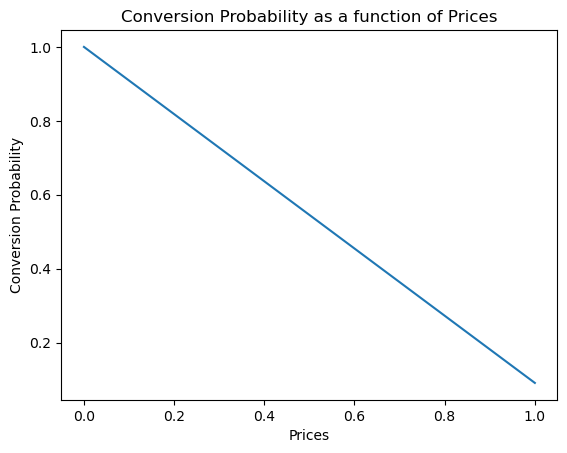

In [23]:
# importing parameters
import importlib
importlib.reload(config)
ITERATIONS = 500#config.ITERATIONS
AUCTIONS = config.AUCTIONS
N_USERS = config.N_USERS
N_ADVERTISERS = config.N_ADVERTISERS    # number of companies that compete for slot auctions, including myself
NUMBER_OF_ARMS = config.NUMBER_OF_ARMS    # needed for the UCB algorithm
PRICES = config.PRICES    # actual arms of the ucb algorithm
BUDGET = config.BUDGET
NUMBER_OF_SLOTS = config.NUMBER_OF_SLOTS
LAMBDAS = np.flip(config.LAMBDAS)
N_TRIALS = 200

my_valuation = 0.8      # randomly chosen
utilities = np.empty((N_TRIALS, ITERATIONS*AUCTIONS))
my_bids = np.empty((N_TRIALS, ITERATIONS*AUCTIONS))
my_payments = np.empty((N_TRIALS, ITERATIONS*AUCTIONS))
my_prices = np.empty((N_TRIALS, ITERATIONS))                # chosen one price for each iteration, not for each auction
total_wins_per_trial = np.zeros(N_TRIALS)
cost = 0.2              # constant (for our purposes) cost of production


conversion_probability = lambda p: 1-p/1.1
#conversion_probability = lambda p: p**2 - 2*p + 1

prices = np.linspace(0, 1, 100)
plt.plot(prices, conversion_probability(prices))
plt.xlabel('Prices')
plt.ylabel('Conversion Probability')
plt.title('Conversion Probability as a function of Prices')

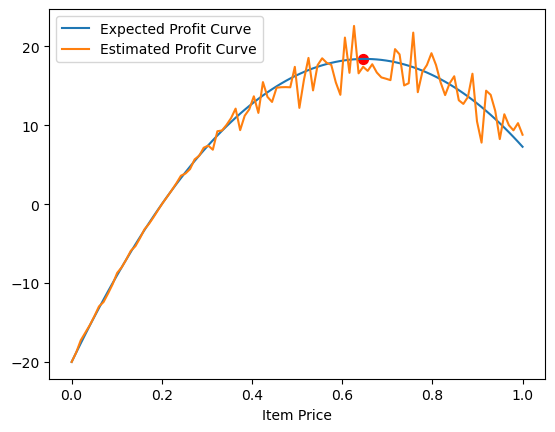

In [24]:
# profit curve = demand curve * profit per price
expected_profit_curve = N_USERS*conversion_probability(prices)*(prices-cost)

estimated_profit_curve = np.random.binomial(N_USERS, conversion_probability(prices))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(expected_profit_curve[best_price_index]/N_USERS, ITERATIONS)

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

In [25]:
def simulation_report(func):
  #@wraps(func)
  def wrapper(*args, **kwargs):
    begin = time.time()
    my_payments, my_bids, utilities, my_prices, total_wins_per_trial, regret_per_trial, tmp_pricing_rewards = func(*args, **kwargs)
    end = time.time()
    print('------------------------- PARAMS -------------------------')
    print(f'- n_trials: {kwargs.get("n_trials")}')
    print(f'- n_days: {kwargs.get("iterations")}')
    print(f'- n_auctions per day: {kwargs.get("auctions")}')
    print(f'- n_advertisers: {kwargs.get("n_advertisers")}')
    print(f'- my valuation: {kwargs.get("my_valuation")}')
    print(f'- production cost: {kwargs.get("cost")}')
    print(f'- budget: {kwargs.get("budget")}')
    print('------------------------- RESULTS -------------------------')
    print(f'Total time taken in {func.__name__} is {round(end - begin,2)} seconds')
    print(f'Percentage of auctions won: {(total_wins_per_trial.mean()*100)/(kwargs.get("iterations")*kwargs.get("auctions"))}')
    print('----------------------------------------------------')

    # let's plot some data
    fig, axs = plt.subplots(nrows=2,ncols=4, figsize=(22,10))
    axs = axs.flatten()

    # plotting the payments
    average_my_payments = np.mean(my_payments, axis=0)
    sd_my_payments = np.std(my_payments, axis=0)
    axs[0].plot(average_my_payments) 
    axs[0].fill_between(range(kwargs.get('iterations')*kwargs.get('auctions')), average_my_payments-sd_my_payments, average_my_payments+sd_my_payments, alpha=0.3)
    axs[0].set_title('Average payments')

    # plotting the bids
    average_my_bids = np.mean(my_bids, axis=0)
    sd_my_bids = np.std(my_bids, axis=0)
    axs[1].plot(average_my_bids)
    axs[1].fill_between(range(len(average_my_bids)), average_my_bids-sd_my_bids, average_my_bids+sd_my_bids, alpha=0.3)
    axs[1].set_title('Average bid value')

    # plotting the utilities
    average_utilities = np.mean(utilities, axis=0)
    sd_utilities = np.std(utilities, axis=0)
    axs[2].plot(average_utilities)
    axs[2].fill_between(range(len(average_utilities)), average_utilities-sd_utilities, average_utilities+sd_utilities, alpha=0.3)
    axs[2].set_title('Average utilities')

    # plotting the prices
    average_prices = np.mean(my_prices, axis=0)
    sd_prices = np.std(my_prices, axis=0)
    axs[3].fill_between(range(len(average_prices)), average_prices-sd_prices, average_prices+sd_prices, alpha=0.3)
    axs[3].plot(average_prices)
    axs[3].set_title('Average prices')
    axs[3].axhline(kwargs.get('best_price'), color='red', label='budget')
    
    # plotting the cumulative payments (how the budget is getting used)
    for i in range(kwargs.get('n_trials')):
      axs[4].plot(np.cumsum(my_payments[i]), label='cumulative payments')
    axs[4].axhline(BUDGET, color='red', label='budget')
    axs[4].set_title("Cumulative payments")
    
    # plotting the regret
    regret_per_trial = np.array(regret_per_trial)
    average_regret = regret_per_trial.mean(axis=0)*kwargs.get('n_users')
    regret_sd = regret_per_trial.std(axis=0)*kwargs.get('n_users')
    axs[5].plot(np.arange(kwargs.get('iterations')), average_regret, label='Average Regret')
    axs[5].set_title('Cumulative regret of UCB1')
    axs[5].fill_between(np.arange(kwargs.get('iterations')),
                    average_regret-regret_sd/np.sqrt(10),
                    average_regret+regret_sd/np.sqrt(10),
                    alpha=0.3,
                    label='Uncertainty')
    #plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
    #axs[5].xlabel('$t$')
    axs[5].legend()

    # plotting the regret value 
    np_tmp_pricing_rewards = np.array(tmp_pricing_rewards)
    axs[6].plot(np_tmp_pricing_rewards.mean(axis=0))
    axs[6].fill_between(range(len(np_tmp_pricing_rewards.mean(axis=0))), np_tmp_pricing_rewards.mean(axis=0)-np_tmp_pricing_rewards.std(axis=0), np_tmp_pricing_rewards.mean(axis=0)+np_tmp_pricing_rewards.std(axis=0), alpha=0.3)
    axs[6].plot(np_tmp_pricing_rewards.mean(axis=0))
    axs[6].set_title("Average pricing rewards")


    fit_window = np.arange(5, kwargs.get('iterations'))
    def model(x, a, b):
        return a*(x**b*(np.log(x)))

    popt, pcov = curve_fit(model, fit_window, average_regret[fit_window])
    ymodel = model(fit_window, *popt)
    axs[7].plot(np.arange(kwargs.get('iterations')), average_regret, label='Empirical Regret')
    axs[7].plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
    axs[7].legend()

    plt.tight_layout()
    plt.show()
    
    
    # Return the original results
    return my_payments, my_bids, utilities, my_prices, total_wins_per_trial, regret_per_trial, tmp_pricing_rewards
    
  return wrapper

In [26]:
@simulation_report
def run_simulation(n_trials, auctions, iterations, n_users, cost, conversion_probability, n_arms, budget, lambdas, n_advertisers, prices, my_valuation, pricing_env, bidding_env, pricing_agent, bidding_agent, best_price):
  # empty arrays for later logging
  utilities = np.empty((n_trials, iterations*auctions))
  my_bids = np.empty((n_trials, iterations*auctions))
  my_payments = np.empty((n_trials, iterations*auctions))
  my_prices = np.empty((n_trials, iterations))                # chosen one price for each iteration, not for each auction
  total_wins_per_trial = np.zeros(n_trials)
  cumulative_regret = np.array([])  
  regret_per_trial = list()
  tmp_pricing_rewards = list()


  for trial in tqdm(range(n_trials)):
    # creating new environments and agents for each independent trial
    pa = pricing_agent(iterations, n_users, cost, conversion_probability, n_arms )
    ba = bidding_agent(budget, iterations, auctions, prices, n_advertisers,n_users, my_valuation)

    pse = pricing_env(conversion_probability, cost)
    bse = bidding_env(B=budget, T=iterations, lambdas=lambdas, n_advertisers=n_advertisers)

    for round in range(iterations):
        p_t = pa.pull_arm()    # pricing agent choose a price p for the product
        my_prices[trial, round] = p_t
        for auction in range(auctions):
            my_bid = ba.action()    # bidding agent decides how much to bid
            other_bids = np.random.uniform(0, 1, size = (n_advertisers)) # size = (N_ADVERTISERS, N_USERS)
            all_bids = np.append(my_bid, other_bids)    # all bids, including mine in first position
            winners, payments_per_click = bse.round(bids=all_bids)    # somebody wins the auction
            my_win = 0 if 0 not in winners else 1       # boolean value which tells if my ad is shown in a slot

            if my_win:
                my_index = np.where(winners==0)[0][0]    # index of the slot where my ad is shown
                f_t, c_t = (my_valuation-payments_per_click[my_index])*my_win, payments_per_click[my_index]*my_win      # could remove my_win
            else:
                f_t, c_t = 0, 0
            ba.update(f_t, c_t)

            # logging
            utilities[trial, round*auctions+auction] = f_t
            my_bids[trial, round*auctions+auction] = my_bid
            my_payments[trial, round*auctions+auction] = c_t
            total_wins_per_trial[trial] += my_win

        d_t, r_t = pse.round(p_t, n_t=n_users)
        pa.update(r_t/n_users)

    tmp_pricing_rewards.append(pa.get_rewards())
    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-pa.get_rewards())
    regret_per_trial.append(cumulative_regret)

  return my_payments, my_bids, utilities, my_prices, total_wins_per_trial, regret_per_trial, tmp_pricing_rewards


100%|██████████| 5/5 [01:11<00:00, 14.23s/it]


------------------------- PARAMS -------------------------
- n_trials: 5
- n_days: 500
- n_auctions per day: 10
- n_advertisers: 10
- my valuation: 0.8
- production cost: 0.2
- budget: 500
------------------------- RESULTS -------------------------
Total time taken in run_simulation is 71.15 seconds
Percentage of auctions won: 95.544
----------------------------------------------------


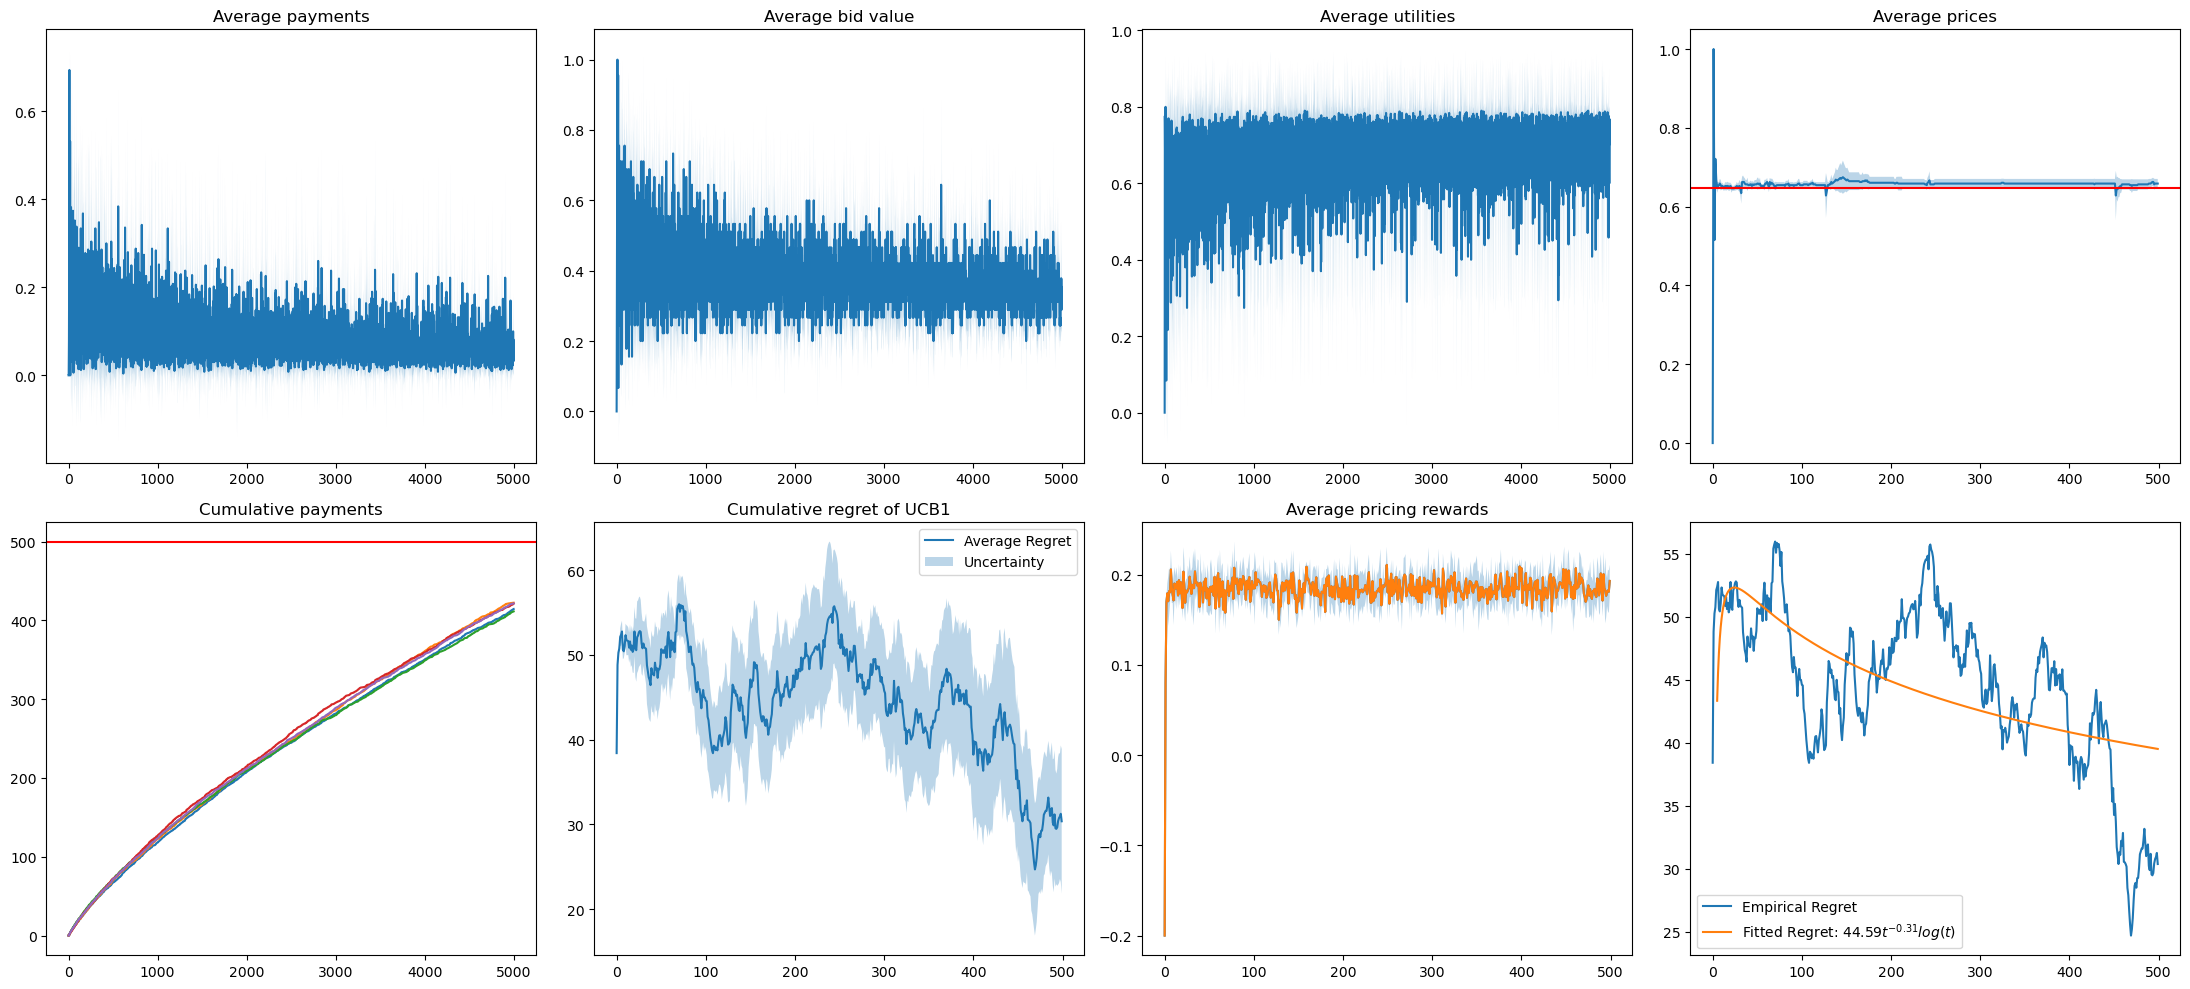

In [27]:
run_simulation(n_trials = 5,#N_TRIALS,
               auctions = AUCTIONS,
               iterations=ITERATIONS,
               n_users=N_USERS,
               cost=cost,
               conversion_probability = conversion_probability,
               n_arms = NUMBER_OF_ARMS,
               budget = BUDGET,
               lambdas = LAMBDAS,
               n_advertisers = N_ADVERTISERS,
               prices = PRICES,
               my_valuation = my_valuation,
               pricing_env = pricing_stochastic_env,
               bidding_env = bidding_stochastic_env,
               pricing_agent = Pricing_agent,
               bidding_agent = UCB_agent,
               best_price = best_price)

print(' ')

100%|██████████| 5/5 [01:09<00:00, 13.99s/it]


------------------------- PARAMS -------------------------
- n_trials: 5
- n_days: 500
- n_auctions per day: 10
- n_advertisers: 10
- my valuation: 0.8
- production cost: 0.2
- budget: 500
------------------------- RESULTS -------------------------
Total time taken in run_simulation is 69.93 seconds
Percentage of auctions won: 98.06799999999998
----------------------------------------------------


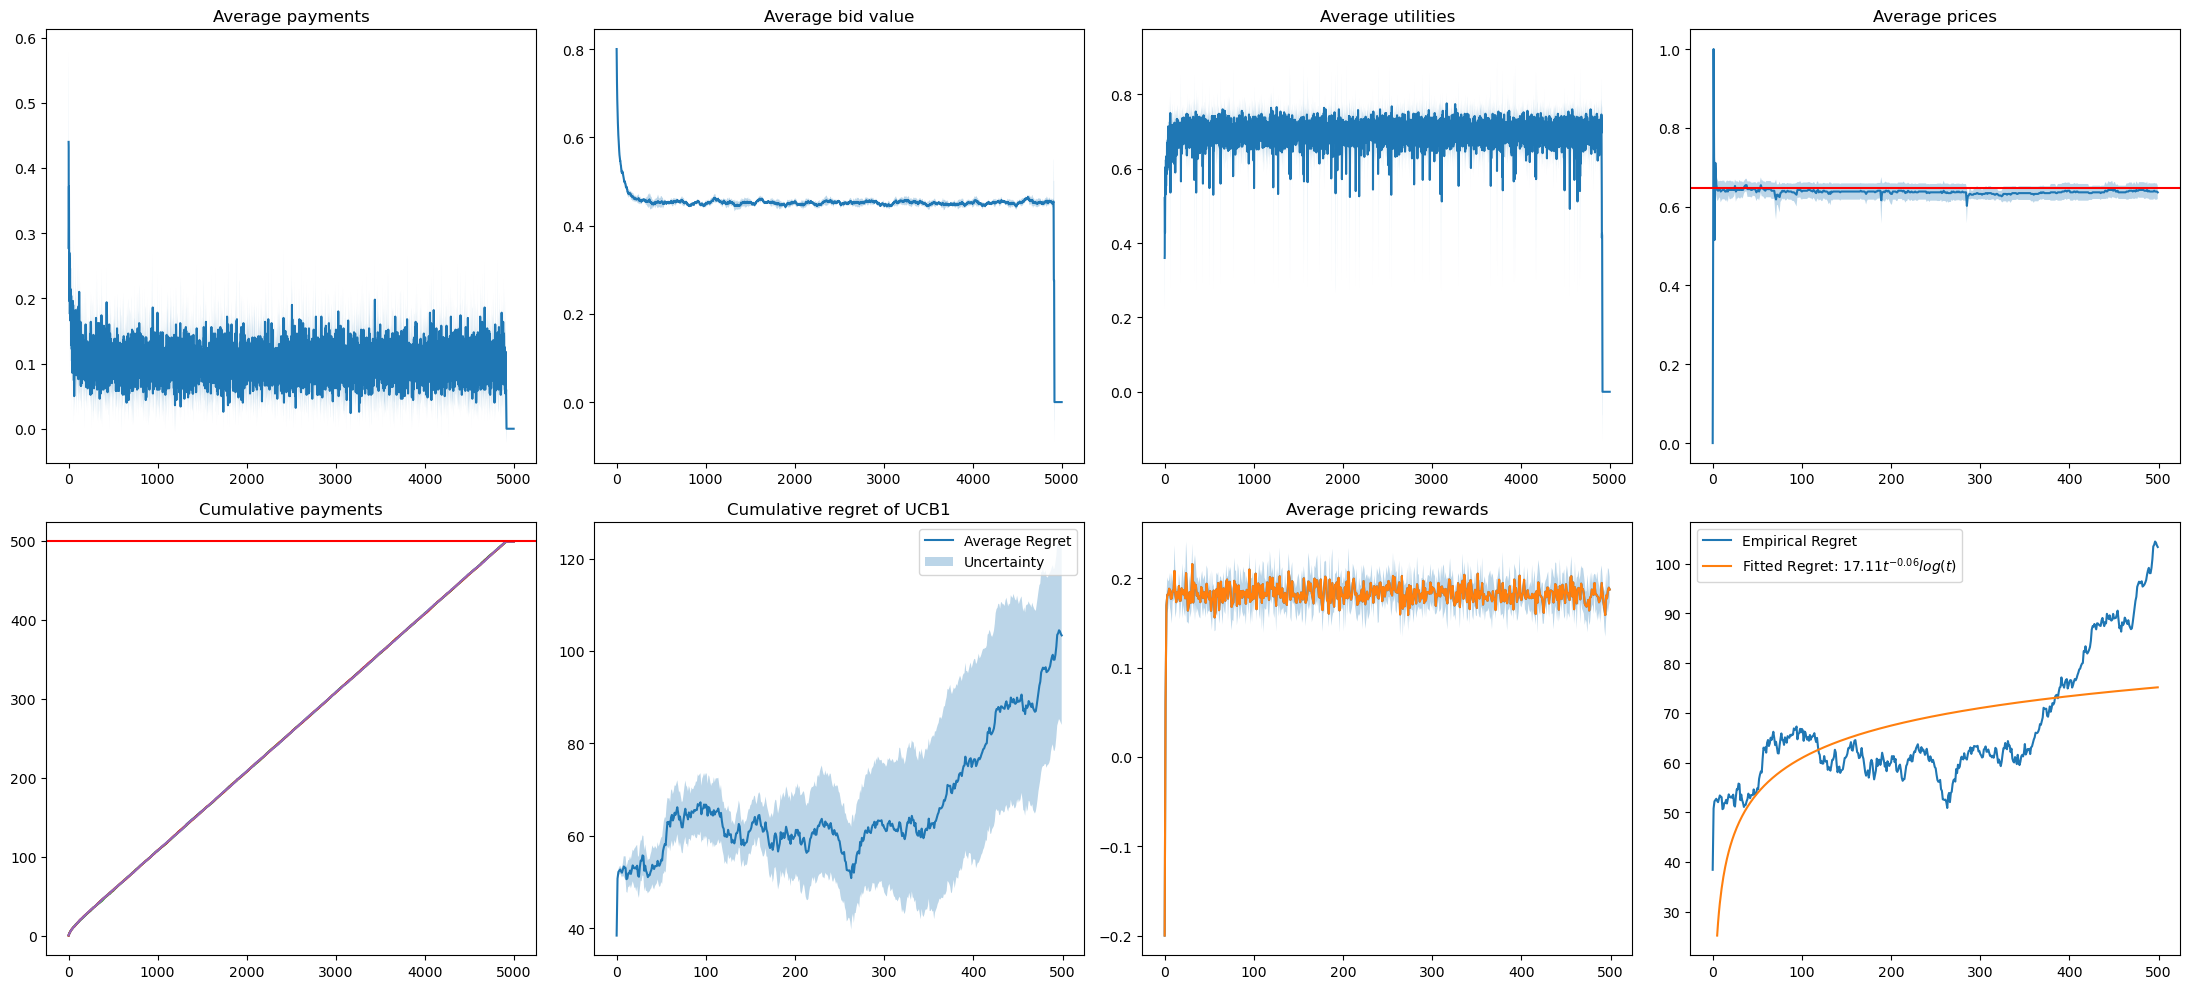

In [35]:
run_simulation(n_trials = 5,#N_TRIALS,
               auctions = AUCTIONS,
               iterations=ITERATIONS,
               n_users=N_USERS,
               cost=cost,
               conversion_probability = conversion_probability,
               n_arms = NUMBER_OF_ARMS,
               budget = BUDGET,
               lambdas = LAMBDAS,
               n_advertisers = N_ADVERTISERS,
               prices = PRICES,
               my_valuation = my_valuation,
               pricing_env = pricing_stochastic_env,
               bidding_env = bidding_stochastic_env,
               pricing_agent = Pricing_agent,
               bidding_agent = primal_dual_agent,
               best_price = best_price)

print(' ')